In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
from nltk.tokenize import sent_tokenize
import pandas as pd
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import config
import tfidf
os.getcwd()

'/Users/Tristan/books/src'

In [ ]:
os.listdir(config.dataset_dir)


In [ ]:
def make_lex_dict(lexicon_file):
        """
        Convert lexicon file to a dictionary
        """
        lex_dict = {}
        for line in lexicon_file.split('\n'):
            (word, measure) = line.strip().split('\t')[0:2]
            lex_dict[word] = float(measure)
        return lex_dict
    
sent_dict = make_lex_dict(open('/Users/Tristan/books/src/' +'vader_lexicon.txt', 'r').read())


Sentiment analysis. Analysis is performed for each sentence and the sentiment scores kept in lists. Sentiment scores are calculated by averaging the sentiment scores for all sentences.

In [ ]:
def return_sentiment_scores(sentence):
    # return just the sentiment scores
    snt = analyser.polarity_scores(sentence)
    return snt

def sentiment_analysis(directory):
    # returns the sentiment of every book in the directory
    data = pd.read_csv(config.dataset_dir + 'output/final_data.csv', index_col=0)
    print(len(data.index))
#     max_amt = len(data.index) + 2
#     print(data.index, len(os.listdir(directory)))
    pos_list = []
    neg_list = []
    neu_list = []
    comp_list = []
    
    # for every book
    for filename in data['filename']:#[:max_amt]:
        
        sub_pos_list = []
        sub_neg_list = []
        sub_neu_list = []
        sub_comp_list = []
        
        # if file is a textfile
        if filename.endswith(".txt"):
            text = open(os.path.join(directory, filename), 'r', errors='replace')
            # for every line in the text
            for line in text.readlines():
                scores = return_sentiment_scores(line)
                # save sentiment scores 
                sub_neg_list.append(scores['neg'])
                sub_neu_list.append(scores['neu'])
                sub_pos_list.append(scores['pos'])
                sub_comp_list.append(scores['compound'])
            
            # then save average sentiment scores for each book
            neg_list.append((sum(sub_neg_list) / float(len(sub_neg_list))))
            pos_list.append((sum(sub_pos_list) / float(len(sub_pos_list))))
            neu_list.append((sum(sub_neu_list) / float(len(sub_neu_list))))
            comp_list.append((sum(sub_comp_list) / float(len(sub_comp_list))))
            
    # convert scores to pandas compatible list
    neg = pd.Series(neg_list)
    pos = pd.Series(pos_list)
    neu = pd.Series(neu_list)
    com = pd.Series(comp_list)

    print(len(neg), len(pos), len(neu), len(com))
    # fill the right columns with the right data
    print(type(data),'type')
    print(neg)
    data['neg score'] = neg.values
    data['pos score'] = pos.values
    data['neu score'] = neu.values
    data['comp score'] = com.values
    data.to_csv(config.dataset_dir + 'output/final_data.csv')
    return data



In [ ]:
analyser = SentimentIntensityAnalyzer()                    
sentiment_analysis(config.dataset_dir + 'test/')

We also want to count the amount of positive and negative words as features. We also create a new file for each book with just the sentiment words. As a result, we will be able to do tfidf on these files later and create wordclouds per genre.

In [ ]:
def count_sentiment_words(directory):
    sent_words_list =[]
    pos_list = []
    neg_list = []
    
    data = pd.read_csv(config.dataset_dir + 'output/final_data.csv', index_col=0)

    for filename in data['filename']:
        sent_words_list =[]
        pos_count = 0
        neg_count = 0
        
        if filename.endswith(".txt"):
            text = open(os.path.join(directory, filename), 'r', errors='replace')
            sentiment_file = open(config.dataset_dir +'output/sentiment_word_texts/' + filename , 'w')

            for line in text.readlines():
                for word in line.split(" "):
                    if word in sent_dict:
                        if sent_dict[word] >= 0:
                            pos_count += 1
                            sent_words_list.append(word)
                            sentiment_file.write("%s" % word)
                            sentiment_file.write(" ")
                        else:
                            neg_count += 1
                            sentiment_file.write("%s" % word)
                            sentiment_file.write(" ")

            pos_list.append(pos_count)
            neg_list.append(neg_count)
            
    data['amt pos'] = pos_list 
    data['amt neg'] = neg_list
    
    data.to_csv(config.dataset_dir + 'output/final_data.csv')
    return data

count_sentiment_words(config.dataset_dir + 'test/')


Thriller (genre)


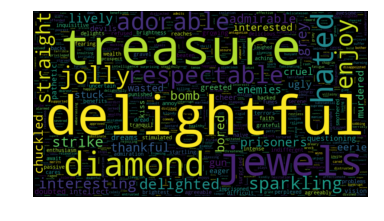

Novel


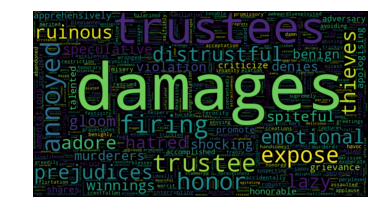

War novel


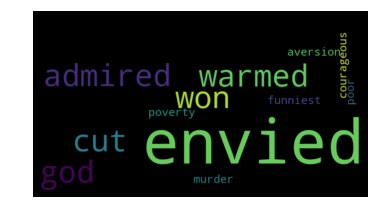

Novella


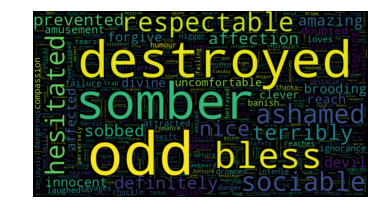

Short story


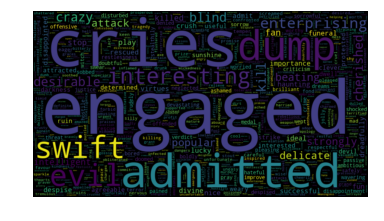

Detective fiction


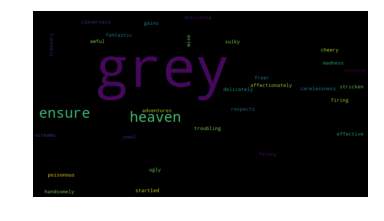

Gothic fiction


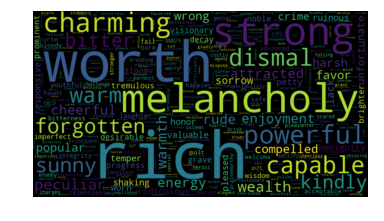

Historical novel


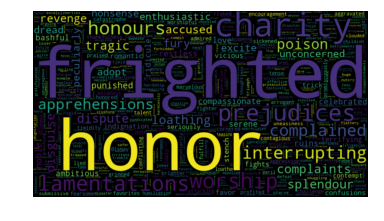

Autobiographical novel


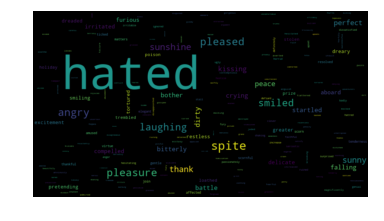

Short stories


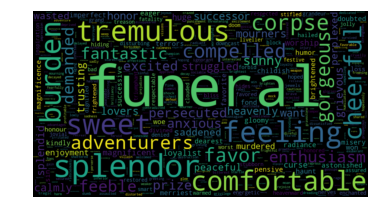

Bildungsroman


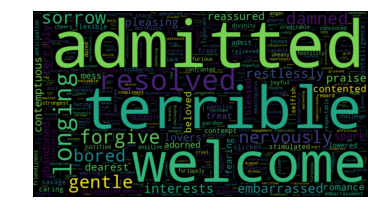

Science fantasy


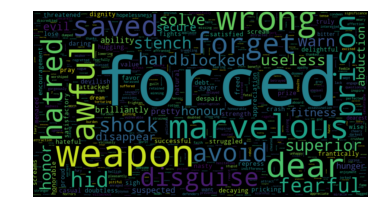

Children's book


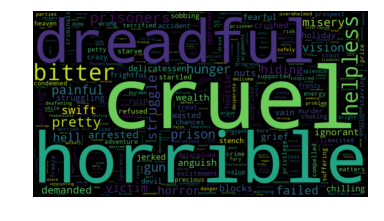

Horror fiction


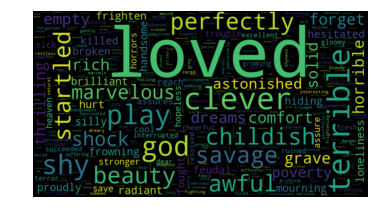

Children's literature


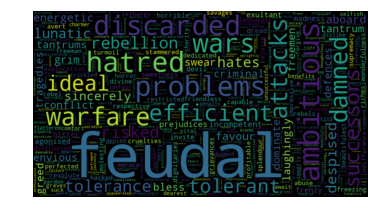

Christian mythology


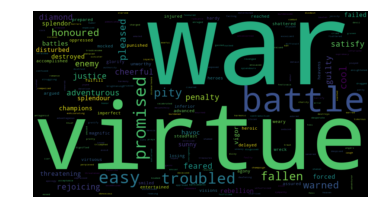

Children's novel


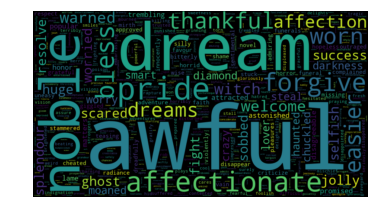

Fantasy novel


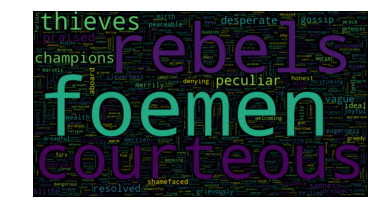

Essay


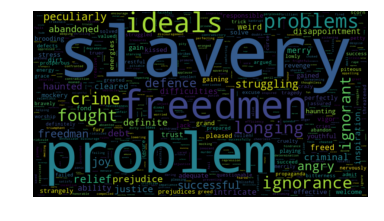

Lost World (genre)


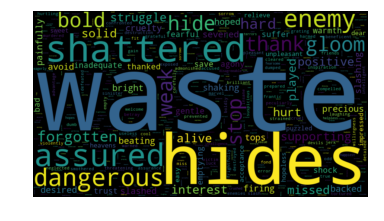

Historical fiction


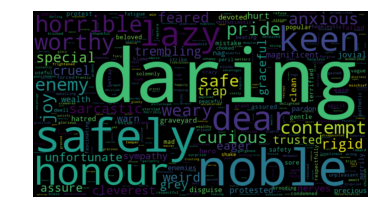

Adventure fiction


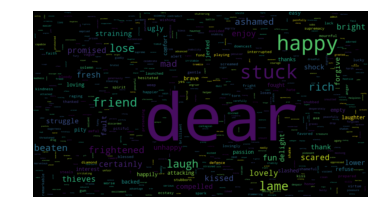

Science fiction


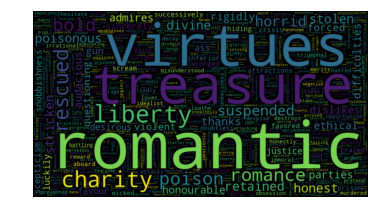

Bush poetry


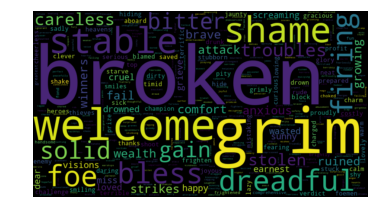

Fiction


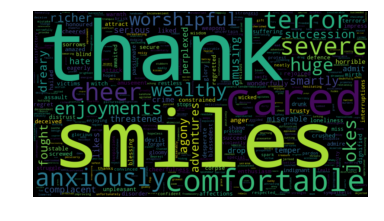

Comedy novel


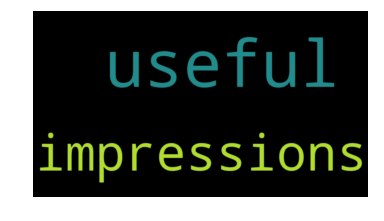

Adventure novel


In [ ]:
def sentiment_words_per_genre():
    data = pd.read_csv(config.dataset_dir + 'output/final_data.csv')
    genres_file = open(config.dataset_dir + 'output/unique_genres.txt', 'r')
    genre_list = [genre.strip('\n') for genre in genres_file.readlines()]
    directory = config.dataset_dir + 'output/sentiment_word_texts/'

    for genre in genre_list:
        books_of_genre = data.loc[data['genre'] == genre]
        book_list = []
        for book in books_of_genre['filename']:
            book_list.append(book)
            
        if len(book_list) > 1:
            print(genre)
            index = tfidf.create_index(directory, book_list)
            tf_matrix = tfidf.create_tf_matrix(directory, book_list)
            tfidf_dict = tfidf.perform_tfidf(directory, book_list, index, tf_matrix)
            
            wordcloud = WordCloud(width=900,height=500, max_words=1628,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(tfidf_dict)

            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.show()
            
        else:
            pass
#         plt.imshow(wordcloud, interpolation='bilinear')
#         plt.axis("off")
#         plt.show()
        
sentiment_words_per_genre()